<a href="https://colab.research.google.com/github/talha-q/talha_Geo6805/blob/main/Lab_5_TIM_AND_SMP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TIM and SMP

Connecting the Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loading Libraries

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms
import timm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
from glob import glob
from pathlib import Path
from osgeo import gdal
import pickle
import random


Checking libraries

In [3]:
print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
PyTorch version 2.6.0+cu124
Torchvision version 0.21.0+cu124
Numpy version 2.0.2
Pandas version 2.2.2


# Classification on UCMerced Dataset

Code for loading Custom Dataset (RS data)

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, img_transform=None, sensor=None):
        self.img_dir = img_dir
        self.img_transform = img_transform
        self.sensor = sensor

        self.tif_files = sorted(glob(os.path.join(self.img_dir, "**", "*.[tT][iI][fF]"), recursive=True))
        sub_folders = sorted(
            class_name for class_name in os.listdir(self.img_dir)
            if os.path.isdir(os.path.join(self.img_dir, class_name))
        )
        self.sub_folder_dict = {class_name: index for index, class_name in enumerate(sub_folders)}

    def __len__(self):
        return len(self.tif_files)

    def __getitem__(self, idx):
        img_path = self.tif_files[idx]
        image_file = gdal.Open(img_path)

        if self.sensor == 'rgb':
            band_r = image_file.GetRasterBand(1).ReadAsArray().astype(np.float32)
            band_g = image_file.GetRasterBand(2).ReadAsArray().astype(np.float32)
            band_b = image_file.GetRasterBand(3).ReadAsArray().astype(np.float32)
            image = np.stack([band_r, band_g, band_b], axis=0)
        elif self.sensor == 'planet':
            band_r = image_file.GetRasterBand(1).ReadAsArray().astype(np.float32)
            band_g = image_file.GetRasterBand(2).ReadAsArray().astype(np.float32)
            band_b = image_file.GetRasterBand(3).ReadAsArray().astype(np.float32)
            band_nir = image_file.GetRasterBand(4).ReadAsArray().astype(np.float32)
            image = np.stack([band_r, band_g, band_b, band_nir], axis=0)
        elif self.sensor == 's1':
            band_vv = image_file.GetRasterBand(1).ReadAsArray().astype(np.float32)
            band_vh = image_file.GetRasterBand(2).ReadAsArray().astype(np.float32)
            image = np.stack([band_vv, band_vh], axis=0)
        else:
            raise ValueError(f"Sensor {self.sensor} not supported")

        if self.img_transform:
            image = self.img_transform(image)

        label = self.sub_folder_dict[Path(img_path).parts[-2]]
        return image, label


In [7]:
#Loading the data
data_path = r"/content/drive/MyDrive/UCMerced_LandUse/Images"
data = CustomImageDataset(data_path, sensor='rgb')
print(data)
print(len(data))
print(data[0])

2100
(array([[[ 44.,  53.,  47., ..., 125., 137., 119.],
        [ 41.,  46.,  44., ...,  83., 124., 135.],
        [ 42.,  44.,  43., ...,  90.,  99., 101.],
        ...,
        [175., 190., 223., ..., 144., 135., 124.],
        [120., 151., 168., ..., 123., 126., 133.],
        [128., 113., 122., ..., 101.,  99., 135.]],

       [[ 41.,  50.,  44., ..., 126., 137., 119.],
        [ 38.,  43.,  41., ...,  83., 124., 131.],
        [ 39.,  41.,  40., ...,  95., 103.,  99.],
        ...,
        [173., 191., 223., ..., 144., 135., 123.],
        [113., 147., 166., ..., 121., 121., 129.],
        [118., 103., 114., ..., 101.,  95., 129.]],

       [[ 45.,  56.,  50., ..., 122., 130., 111.],
        [ 42.,  46.,  45., ...,  81., 118., 126.],
        [ 43.,  44.,  44., ...,  91.,  98.,  97.],
        ...,
        [175., 189., 221., ..., 136., 126., 118.],
        [120., 150., 165., ..., 117., 117., 124.],
        [127., 110., 118., ...,  99.,  94., 127.]]], dtype=float32), 0)


Randomly selecting training data from the dataset, Using 30 percent of the total dataset.

In [8]:
# using random seed so we get the same random set everytime
random.seed("seed1")
samplesize = int(0.3 * len(data))

print(f"****Random Sample Data****\nselecting 30% from the dataset of {len(data)}\nSample size for training is {samplesize}\n")
sampleidx = random.sample(range(len(data)), samplesize)
print(f"***Randomly sampled {samplesize} indices from dataset***\n{sampleidx}")


****Random Sample Data****
selecting 30% from the dataset of 2100
Sample size for training is 630

***Randomly sampled 630 indices from dataset***
[709, 2041, 1401, 1570, 1002, 1960, 1372, 279, 81, 946, 421, 332, 834, 147, 121, 2093, 771, 2062, 50, 189, 1073, 1725, 1225, 800, 1487, 1553, 510, 1993, 200, 1686, 907, 966, 1140, 1078, 1787, 625, 634, 1468, 289, 1139, 275, 405, 140, 1910, 413, 546, 725, 462, 1625, 1486, 1733, 1383, 82, 1039, 746, 591, 162, 1131, 406, 646, 1583, 1912, 829, 1283, 868, 1366, 66, 1211, 639, 465, 1828, 1013, 1629, 399, 1395, 754, 1272, 1107, 812, 901, 1797, 633, 789, 2098, 1842, 1467, 1, 337, 2077, 1432, 1413, 1510, 710, 149, 300, 1095, 2001, 2037, 1982, 1400, 1017, 1517, 209, 1815, 930, 1090, 1716, 762, 643, 1965, 1202, 561, 737, 491, 1471, 1346, 1150, 1349, 1766, 745, 931, 277, 1585, 910, 418, 524, 349, 226, 461, 1578, 2094, 2059, 667, 700, 956, 1859, 1154, 1864, 452, 785, 1218, 1677, 88, 2050, 1866, 916, 1209, 1776, 323, 280, 407, 1415, 2027, 1390, 875, 502, 

In [9]:
print(type(data))
sample_data = [data[i] for i in tqdm(sampleidx, desc="Sampling data")]


<class '__main__.CustomImageDataset'>


Sampling data:   0%|          | 0/630 [00:00<?, ?it/s]

In [ ]:
# image, _ = sample_data[0]
# print(image.shape)
# print(range(image.shape[0])) basically the same thing as num_bands below.

In [10]:
num_bands = sample_data[0][0].shape[0] #number of bands  in the sampled data
print(f"Number of bands in the sampled data: {num_bands}")

#Creating an empty list to flatten and store the bands
flatnBandList=[]
flatnBandList = [[] for i in range(num_bands)]
print(flatnBandList)

# Loop over each sample in the dataset
for sample in tqdm(sample_data, desc="Flattening and Storing Bands"):
    image, _ = sample  # unpack image and ignore label
    for i in range(num_bands):
        flatnBandList[i].append(image[i].flatten())
print(len(flatnBandList))

Number of bands in the sampled data: 3
[[], [], []]


Flattening and Storing Bands:   0%|          | 0/630 [00:00<?, ?it/s]

3


In [11]:
means = []
stds = []
abs_means = []
abs_stds = []

for band_values in flatnBandList:
    # Convert each array in the band to a float32 tensor
    tensors = [torch.tensor(arr, dtype=torch.float32) for arr in band_values]

    # Concatenate all tensors into one long 1D tensor
    all_pixels = torch.cat(tensors)

    # Compute raw mean and std
    means.append(all_pixels.mean().item())
    stds.append(all_pixels.std().item())

    # Compute absolute mean and std (optional, if required)
    abs_pixels = torch.abs(all_pixels)
    abs_means.append(abs_pixels.mean().item())
    abs_stds.append(abs_pixels.std().item())

print("Band-wise means:", means)
print("Band-wise stds:", stds)
print("Absolute Band-wise means:", abs_means)
print("Absolute Band-wise stds:", abs_stds)

stats = {
    "means": means,
    "stds": stds
}

# Save to file
with open("band_stats.pkl", "wb") as f:
    pickle.dump(stats, f)

with open("band_stats.pkl", "rb") as f:
    loaded_stats = pickle.load(f)

print(f"Band Stat Pickle file loaded successfully. Loaded stats: {loaded_stats}")


Band-wise means: [122.29682922363281, 124.2139663696289, 114.55428314208984]
Band-wise stds: [55.91888427734375, 51.48283004760742, 49.94414520263672]
Absolute Band-wise means: [122.29682922363281, 124.2139663696289, 114.55428314208984]
Absolute Band-wise stds: [55.91888427734375, 51.48283004760742, 49.94414520263672]
Band Stat Pickle file loaded successfully. Loaded stats: {'means': [122.29682922363281, 124.2139663696289, 114.55428314208984], 'stds': [55.91888427734375, 51.48283004760742, 49.94414520263672]}


Custom Transformation

In [12]:
from torchvision.transforms import v2

class CustomAugmentation:
    def __init__(self, resize_size=(256, 256), crop_size=(224, 224),
                 do_resize=True, do_random_crop=True, do_horizontal_flip=True, do_random_hue=True):
        self.resize_size = resize_size
        self.crop_size = crop_size
        self.do_resize = do_resize
        self.do_random_crop = do_random_crop
        self.do_horizontal_flip = do_horizontal_flip
        self.do_random_hue = do_random_hue

    def __call__(self, image):
        if self.do_resize:
            image = v2.functional.resize(image, self.resize_size, antialias=True)

        if self.do_random_crop:
            _, height, width = image.shape
            crop_height, crop_width = self.crop_size
            top = torch.randint(0, height - crop_height + 1, (1,)).item()
            left = torch.randint(0, width - crop_width + 1, (1,)).item()
            image = v2.functional.crop(image, top, left, crop_height, crop_width)

        if self.do_horizontal_flip and torch.rand(1) > 0.5:
            image = v2.functional.horizontal_flip(image)

        if self.do_random_hue and torch.rand(1) > 0.5 and image.shape[0] >= 3:
            image[:3] = v2.functional.adjust_hue(image[:3], torch.empty(1).uniform_(-0.1, 0.1).item())

        return image




Z Score Normalization
`

In [13]:
# Load from pickle
with open("band_stats.pkl", "rb") as f:
    loaded_stats = pickle.load(f)

class z_score_form_stats:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(-1, 1, 1) #(C,W,H)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def __call__(self, image):
        return (image - self.mean) / (self.std + 1e-6)

# Final transformation pipeline
custom_transform = transforms.Compose([
    lambda x: torch.from_numpy(x).float(),
    CustomAugmentation(resize_size=(256, 256), crop_size=(224, 224), do_random_hue=False),
    z_score_form_stats(mean=loaded_stats["means"], std=loaded_stats["stds"])
])


In [14]:
# Apply the final transform to full dataset
data_path =r"/content/drive/MyDrive/UCMerced_LandUse/Images"

mydataset_full = CustomImageDataset(data_path, img_transform=custom_transform, sensor='rgb')
print(len(mydataset_full))
print(mydataset_full[1])

# Split sizes
train_size = int(0.7 * len(mydataset_full))
val_size   = int(0.1 * len(mydataset_full))
test_size  = len(mydataset_full) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(mydataset_full, [train_size, val_size, test_size])

# Save paths
train_paths = [mydataset_full.tif_files[i] for i in train_dataset.indices]
val_paths   = [mydataset_full.tif_files[i] for i in val_dataset.indices]
test_paths  = [mydataset_full.tif_files[i] for i in test_dataset.indices]

splits_dict = {
    "train_paths": train_paths,
    "val_paths": val_paths,
    "test_paths": test_paths
}

with open("splits.pkl", "wb") as f:
    pickle.dump(splits_dict, f)

# To reload:
with open("splits.pkl", "rb") as f:
    loaded_splits = pickle.load(f)

print("Train:", len(loaded_splits["train_paths"]))
print("Validation:", len(loaded_splits["val_paths"]))
print("Test:", len(loaded_splits["test_paths"]))


2100
(tensor([[[-0.2020, -0.1841, -0.2020,  ...,  0.3702,  0.3345, -0.0947],
         [-0.0411,  0.2808,  0.2808,  ..., -0.1126,  0.2451,  0.2987],
         [ 0.5133,  1.1392,  0.1020,  ..., -0.4703, -0.4524,  0.2093],
         ...,
         [ 0.3881,  0.6027, -0.6312,  ..., -0.1305, -0.1126, -0.2557],
         [-0.0590, -0.0590, -0.4882,  ...,  0.1199,  0.0662,  0.1020],
         [ 0.0841, -0.0768, -0.1305,  ..., -0.1126,  0.0483,  0.1556]],

        [[-0.2372, -0.1984, -0.2178,  ...,  0.3066,  0.3066, -0.2178],
         [-0.1595,  0.2872,  0.2678,  ..., -0.2178,  0.1707,  0.2095],
         [ 0.4232,  1.1613,  0.0153,  ..., -0.5286, -0.5675,  0.1318],
         ...,
         [ 0.5009,  0.5980, -0.8394,  ..., -0.1207, -0.0430, -0.1595],
         [-0.0042, -0.0819, -0.5092,  ...,  0.1124,  0.1124,  0.2484],
         [ 0.0347, -0.0819, -0.0236,  ..., -0.1984,  0.0347,  0.2095]],

        [[-0.1713, -0.0311, -0.0712,  ...,  0.3893,  0.3893, -0.0912],
         [-0.1112,  0.3293,  0.3493,  .

**********************************************************************
*********************************************************************
***********************************************************************

# Assignment 1: Using Timm to train a classification model

In [16]:
import timm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=21)
model.to(device)


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

##Training and Validation

Epoch 1: Train Loss = 2.7207, Val Loss = 2.3908
Epoch 2: Train Loss = 2.0817, Val Loss = 1.9558
Epoch 3: Train Loss = 1.7274, Val Loss = 1.7486
Epoch 4: Train Loss = 1.5196, Val Loss = 1.7489
Epoch 5: Train Loss = 1.3741, Val Loss = 1.4505
✅ Transformer model saved as vit_ucmerced.pth


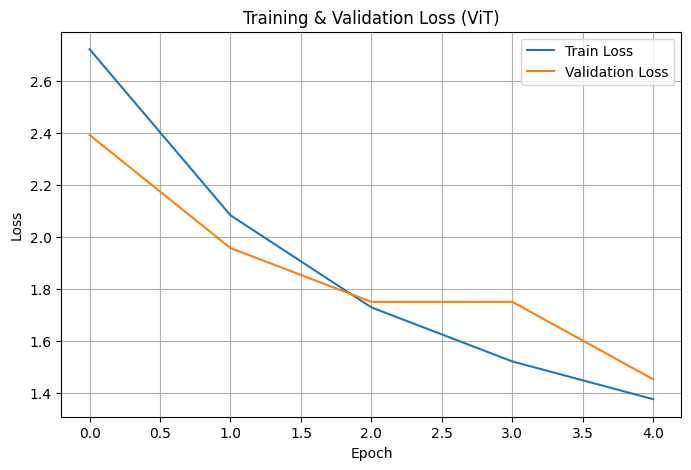

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import timm

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# DataLoaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model: Replace ResNet with Vision Transformer
model = timm.create_model('vit_base_patch16_224', pretrained=False, num_classes=21).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# For tracking
train_losses, val_losses = [], []
best_val_loss = float('inf')
best_model_state = None

# Training loop (5 epochs)
for epoch in range(1, 6):
    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()

# Best Model Load and Save
model.load_state_dict(best_model_state)
torch.save(model.state_dict(), "vit_ucmerced.pth")
print("✅ Transformer model saved as vit_ucmerced.pth")


In [ ]:
#Assignment 2 UNet++

In [23]:
# Let's import the necessary libraries in first
import os
import torch
import torch.nn as nn # nn is the linear transformation function in PyTorch, it is the fully connected layer
import torch.optim as optim # optim is the optimization function in PyTorch, the gradient descent algorithm(adam, sdg)
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import timm #this one contains the pre-trained models
import matplotlib.pyplot as plt # For data viz
import pandas as pd
import numpy as np
import sys
from tqdm.notebook import tqdm
from glob import glob
from pathlib import Path

from osgeo import gdal
from glob import glob
from collections import defaultdict

print('System Version:', sys.version)
print('PyTorch version', torch.__version__)
print('Torchvision version', torchvision.__version__)
print('Numpy version', np.__version__)
print('Pandas version', pd.__version__)

System Version: 3.11.12 (main, Apr  9 2025, 08:55:54) [GCC 11.4.0]
PyTorch version 2.6.0+cu124
Torchvision version 0.21.0+cu124
Numpy version 2.0.2
Pandas version 2.2.2


In [24]:
#for removing the folder if it is already there.
!rm -r /content/chipped_dataset/


Chipping images and storing them

In [25]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from osgeo import gdal
from glob import glob
from tqdm import tqdm

# === Relabel function ===
def relabel_mask(mask):
    mask = np.where((mask == 2) | (mask == 3), 4, mask)
    mask = np.where(mask == 1, 0, mask)
    mask = np.where(mask == 4, 1, mask)
    return mask

# === Dataset class ===
class SegmentationDataset(Dataset):
    def __init__(self, img_dir):
        self.img_dir = img_dir
        self.img_files = sorted(glob(os.path.join(self.img_dir, "PS", "*.[tT][iI][fF]")))

    def __len__(self):
        return len(self.img_files)

    def _read_image(self, img_path):
        ds = gdal.Open(img_path)
        self.geotransform = ds.GetGeoTransform()
        self.projection = ds.GetProjection()
        num_bands = ds.RasterCount

        bands = [ds.GetRasterBand(i + 1).ReadAsArray().astype(np.uint8) for i in range(num_bands)]
        image = np.stack(bands, axis=0)
        return image

    def _read_label(self, label_path):
        ds = gdal.Open(label_path)
        label = ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)
        return label

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        label_path = img_path.replace("PS", "labels")

        image = self._read_image(img_path)
        label = self._read_label(label_path)

        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).long()

        return image, label, os.path.splitext(os.path.basename(img_path))[0], self.geotransform, self.projection

# === Save chips ===
def chip_and_save(image, label, img_name, out_img_dir, out_lbl_dir,
                  chip_size=256, stride=256, geotransform=None, projection=None):
    h, w = image.shape[1:]
    num_bands = image.shape[0]
    count = 0

    for i in range(0, h, stride):
        for j in range(0, w, stride):
            i_end = min(i + chip_size, h)
            j_end = min(j + chip_size, w)
            i_start = i_end - chip_size
            j_start = j_end - chip_size
            if i_start < 0 or j_start < 0:
                continue

            img_chip = image[:, i_start:i_end, j_start:j_end]
            lbl_chip = label[i_start:i_end, j_start:j_end]

            if img_chip.shape[1:] != (chip_size, chip_size):
                continue

            chip_name = f"{img_name}_chip_{count}.tif"
            img_chip_path = os.path.join(out_img_dir, chip_name)
            lbl_chip_path = os.path.join(out_lbl_dir, chip_name)

            driver = gdal.GetDriverByName('GTiff')
            img_ds = driver.Create(img_chip_path, chip_size, chip_size, num_bands, gdal.GDT_Byte)
            lbl_ds = driver.Create(lbl_chip_path, chip_size, chip_size, 1, gdal.GDT_Byte)

            if geotransform:
                origin_x = geotransform[0] + j_start * geotransform[1]
                origin_y = geotransform[3] + i_start * geotransform[5]
                chip_transform = (origin_x, geotransform[1], 0.0, origin_y, 0.0, geotransform[5])
                img_ds.SetGeoTransform(chip_transform)
                lbl_ds.SetGeoTransform(chip_transform)
                if projection:
                    img_ds.SetProjection(projection)
                    lbl_ds.SetProjection(projection)

            for band_num in range(num_bands):
                img_ds.GetRasterBand(band_num + 1).WriteArray(img_chip[band_num].numpy())
            lbl_ds.GetRasterBand(1).WriteArray(lbl_chip.numpy())

            img_ds = None
            lbl_ds = None
            count += 1

# === Main chipping function ===
def chip_dataset(root_img_dir, output_root, chip_size=256):
    out_img_dir = os.path.join(output_root, "PS")
    out_lbl_dir = os.path.join(output_root, "labels")
    os.makedirs(out_img_dir, exist_ok=True)
    os.makedirs(out_lbl_dir, exist_ok=True)

    dataset = SegmentationDataset(root_img_dir)

    for i in range(len(dataset)):
        image, label, img_name, gt, proj = dataset[i]
        label = torch.from_numpy(relabel_mask(label.numpy()))
        chip_and_save(image, label, img_name, out_img_dir, out_lbl_dir, chip_size=chip_size,
                      geotransform=gt, projection=proj)

# === Function to print shapes of saved chips ===
def print_chipped_shapes(chipped_folder):
    img_files = sorted(glob(os.path.join(chipped_folder, "PS", "*.tif")))
    print(f"\n✅ Total chipped images: {len(img_files)}\n")

    for f in img_files:
        ds = gdal.Open(f)
        width = ds.RasterXSize
        height = ds.RasterYSize
        bands = ds.RasterCount
        print(f"{os.path.basename(f)} - Shape: {height} x {width}, Bands: {bands}")

# === Run it all ===
if __name__ == "__main__":
    input_folder = "/content/drive/MyDrive/GlobalSurfaceWaterDataset(1)/GlobalSurfaceWaterDataset"
    output_folder = "chipped_dataset"

    chip_dataset(input_folder, output_folder)


Checking the size and bands of images

In [26]:
import os
from osgeo import gdal
from glob import glob

# Path to your images
#image_dir = "/content/drive/MyDrive/GlobalSurfaceWaterDataset(1)/GlobalSurfaceWaterDataset/PS"
image_dir = "/content/chipped_dataset/PS"


image_paths = sorted(glob(os.path.join(image_dir, "*.tif")))

print(f"Found {len(image_paths)} TIFF images.\n")

for path in image_paths:
    ds = gdal.Open(path)
    if ds is None:
        print(f"Could not open {os.path.basename(path)}")
        continue

    width = ds.RasterXSize
    height = ds.RasterYSize
    bands = ds.RasterCount
    num_pixels = height * width * bands
    size_mb = os.path.getsize(path) / (1024 * 1024)

    print(f"{os.path.basename(path)} → "
          f"Shape: {height}x{width}, "
          f"Bands: {bands}, "
          f"Total Pixels: {num_pixels}, "
          f"Size: {size_mb:.2f} MB")


Found 1811 TIFF images.

SID01_chip_0.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_1.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_10.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_11.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_12.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_13.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_14.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_15.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_16.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_17.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_18.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0.50 MB
SID01_chip_19.tif → Shape: 256x256, Bands: 8, Total Pixels: 524288, Size: 0

In [27]:
import os
import torch
import numpy as np
from osgeo import gdal
from glob import glob
from tqdm import tqdm
import pickle

# === Configuration ===
ps_folder = "/content/chipped_dataset/PS"  # <-- Update to your folder
num_bands = 8  # Red, Green, Blue, NIR

# === Load image paths ===
image_paths = sorted(glob(os.path.join(ps_folder, "*.tif")))
print(f"Found {len(image_paths)} images.")

# === Band-wise storage ===
flatnBandList = [[] for _ in range(num_bands)]

# === Process images ===
for path in tqdm(image_paths, desc="Reading images"):
    ds = gdal.Open(path)
    if ds is None:
        print(f" Could not open {path}")
        continue

    band_count = ds.RasterCount
    if band_count < num_bands:
        print(f" Skipping {os.path.basename(path)} — only {band_count} bands found.")
        continue

    for i in range(num_bands):
        band = ds.GetRasterBand(i + 1).ReadAsArray().astype(np.float32)
        flatnBandList[i].append(torch.from_numpy(band).flatten())

# === Compute stats ===
means, stds = [], []
for i, band_data in enumerate(flatnBandList):
    all_pixels = torch.cat(band_data)
    means.append(all_pixels.mean().item())
    stds.append(all_pixels.std().item())

# === Output ===
print("\nBand-wise Means:", means)
print(" Band-wise Standard Deviations:", stds)

# === Save to file (optional)
stats = {"means": means, "stds": stds}
with open("bandstats.pkl", "wb") as f:
    pickle.dump(stats, f)
print("Saved band stats to bandstats.pkl")


Found 1811 images.


Reading images: 100%|██████████| 1811/1811 [00:07<00:00, 226.40it/s]



Band-wise Means: [118.29904174804688, 129.00457763671875, 118.03889465332031, 120.23979949951172, 116.89582061767578, 121.523681640625, 120.2465591430664, 119.38862609863281]
 Band-wise Standard Deviations: [78.42156982421875, 77.57292938232422, 75.61328887939453, 75.92793273925781, 75.53909301757812, 76.77102661132812, 76.22856903076172, 75.55461883544922]
Saved band stats to bandstats.pkl


In [28]:
with open("bandstats.pkl", "rb") as f:
    loaded_stats = pickle.load(f)
class z_score_form_stats:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(-1, 1, 1)  # [C, 1, 1]
        self.std = torch.tensor(std).view(-1, 1, 1)

    def __call__(self, image):
        return (image - self.mean) / (self.std + 1e-6)


In [37]:
#those are new libs compared to last time
from torchvision.transforms import v2 # this lib supports data augmentation
from torch.utils.data import Dataset, ConcatDataset
# important: the data augmentation methods takes input shape as (c,h,w) for both img and labels, but our label is actually (h,w), we need to add adimention when doing data augmentation to label. but the model loss eval actually takes only (h,w) for label. so after data augmentation, we need to convert label back to (w,h)
class SegmentationAugmentation:
    """Class containing all augmentation methods for segmentation tasks"""
    def no_augmentation(self, image, label):
        """Return image and label without any augmentation"""
        return image, label

    def horizontal_flip(self, image, label):
        """Apply horizontal flip to both image and label (spatial transform)"""
        image = v2.functional.horizontal_flip(image)
        label = label.unsqueeze(0) # convert label to (c,w,h)
        label = v2.functional.horizontal_flip(label)
        return image, label

    def vertical_flip(self, image, label):
        """Apply vertical flip to both image and label (spatial transform)"""
        image = v2.functional.vertical_flip(image)
        label = label.unsqueeze(0)
        label = v2.functional.vertical_flip(label)
        return image, label

    def rotate_90(self, image, label):
        """Apply 90-degree rotation to both image and label (spatial transform)"""
        image = v2.functional.rotate(image, 90)
        label = label.unsqueeze(0)
        label = v2.functional.rotate(label, 90, interpolation=v2.InterpolationMode.NEAREST)
        return image, label

    # We will not do random crop this time since they need to be resized, and we definately do not want to resize the label. Resizing will generate synsetic data that
    # will provide false information to the model

    def color_jitter(self, image, label, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
        """Apply color augmentations to image only (non-spatial transform)"""
        # Only modify the image, not the label
        if image.shape[0] >= 3:  # Only if we have RGB channels
            if torch.rand(1) > 0.5:
                image[:3] = v2.functional.adjust_brightness(
                    image[:3], 1.0 + torch.empty(1).uniform_(-brightness, brightness).item()
                )
            if torch.rand(1) > 0.5:
                image[:3] = v2.functional.adjust_contrast(
                    image[:3], 1.0 + torch.empty(1).uniform_(-contrast, contrast).item()
                )
            if torch.rand(1) > 0.5:
                image[:3] = v2.functional.adjust_saturation(
                    image[:3], 1.0 + torch.empty(1).uniform_(-saturation, saturation).item()
                )
            if torch.rand(1) > 0.5:
                image[:3] = v2.functional.adjust_hue(
                    image[:3], torch.empty(1).uniform_(-hue, hue).item()
                )

        # Label remains unchanged
        return image, label




In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset, Dataset
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, jaccard_score
import segmentation_models_pytorch as smp
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import os
import pickle
from glob import glob
from osgeo import gdal
import torchvision.transforms.v2 as v2

# === CONFIG ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_dir = Path('./checkpoints_smp')
checkpoint_dir.mkdir(exist_ok=True)

class z_score_form_stats:
    def __init__(self, mean, std):
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def __call__(self, image):
        return (image - self.mean) / (self.std + 1e-6)

class SegmentationAugmentation:
    def no_augmentation(self, image, label):
        return image, label

    def horizontal_flip(self, image, label):
        image = v2.functional.horizontal_flip(image)
        label = label.unsqueeze(0)
        label = v2.functional.horizontal_flip(label)
        return image, label.squeeze(0)

    def vertical_flip(self, image, label):
        image = v2.functional.vertical_flip(image)
        label = label.unsqueeze(0)
        label = v2.functional.vertical_flip(label)
        return image, label.squeeze(0)

    def rotate_90(self, image, label):
        image = v2.functional.rotate(image, 90)
        label = label.unsqueeze(0)
        label = v2.functional.rotate(label, 90, interpolation=v2.InterpolationMode.NEAREST)
        return image, label.squeeze(0)

    def color_jitter(self, image, label, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
        if image.shape[0] >= 3:
            if torch.rand(1) > 0.5:
                image[:3] = v2.functional.adjust_brightness(image[:3], 1.0 + torch.empty(1).uniform_(-brightness, brightness).item())
            if torch.rand(1) > 0.5:
                image[:3] = v2.functional.adjust_contrast(image[:3], 1.0 + torch.empty(1).uniform_(-contrast, contrast).item())
            if torch.rand(1) > 0.5:
                image[:3] = v2.functional.adjust_saturation(image[:3], 1.0 + torch.empty(1).uniform_(-saturation, saturation).item())
            if torch.rand(1) > 0.5:
                image[:3] = v2.functional.adjust_hue(image[:3], torch.empty(1).uniform_(-hue, hue).item())
        return image, label

class SegmentationDataset(Dataset):
    def __init__(self, img_dir, augmentation_method=None, sensor='rgb', normalize=True, mode='folder'):
        self.img_dir = img_dir
        self.augmentation_method = augmentation_method
        self.sensor = sensor
        self.normalize = normalize
        self.mode = mode
        self.augmentation = SegmentationAugmentation()

        if self.normalize:
            with open("bandstats.pkl", "rb") as f:
                stats = pickle.load(f)
            self.normalizer = z_score_form_stats(mean=stats["means"], std=stats["stds"])

        if self.mode == 'folder':
            self.img_files = sorted(glob(os.path.join(self.img_dir, "PS", "*.tif")))
        elif self.mode == 'list':
            self.img_files = self.img_dir

    def __len__(self):
        return len(self.img_files)

    def _read_image(self, img_path):
        ds = gdal.Open(img_path)
        bands = [ds.GetRasterBand(i + 1).ReadAsArray().astype(np.float32) for i in range(ds.RasterCount)]
        return np.stack(bands, axis=0)

    def _read_label(self, label_path):
        ds = gdal.Open(label_path)
        return ds.GetRasterBand(1).ReadAsArray().astype(np.uint8)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        label_path = img_path.replace("PS", "labels")

        image = torch.from_numpy(self._read_image(img_path)).float()
        label = torch.from_numpy(self._read_label(label_path)).long()

        if self.augmentation_method:
            aug = getattr(self.augmentation, self.augmentation_method)
            image, label = aug(image, label)

        if self.normalize:
            image = self.normalizer(image)

        return image, label



=== Fold 1/6 ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Fold 1 Epoch 1: 100%|██████████| 755/755 [07:47<00:00,  1.61it/s]


Epoch 1: Train Loss = 0.4168, Val Loss = 0.3228, F1 = 0.5802, IoU = 0.4820


Fold 1 Epoch 2: 100%|██████████| 755/755 [07:42<00:00,  1.63it/s]


Epoch 2: Train Loss = 0.3140, Val Loss = 0.2892, F1 = 0.6035, IoU = 0.5063


Fold 1 Epoch 3: 100%|██████████| 755/755 [07:44<00:00,  1.63it/s]


Epoch 3: Train Loss = 0.2743, Val Loss = 0.2630, F1 = 0.6413, IoU = 0.5436


Fold 1 Epoch 4: 100%|██████████| 755/755 [07:41<00:00,  1.64it/s]


Epoch 4: Train Loss = 0.2531, Val Loss = 0.2659, F1 = 0.6378, IoU = 0.5489


Fold 1 Epoch 5: 100%|██████████| 755/755 [07:41<00:00,  1.64it/s]


Epoch 5: Train Loss = 0.2308, Val Loss = 0.2511, F1 = 0.6767, IoU = 0.5850

=== Fold 2/6 ===


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
Fold 2 Epoch 1: 100%|██████████| 755/755 [07:42<00:00,  1.63it/s]


Epoch 1: Train Loss = 0.4176, Val Loss = 0.3358, F1 = 0.6455, IoU = 0.5355


Fold 2 Epoch 2: 100%|██████████| 755/755 [07:41<00:00,  1.63it/s]


Epoch 2: Train Loss = 0.3206, Val Loss = 0.2727, F1 = 0.6685, IoU = 0.5726


Fold 2 Epoch 3: 100%|██████████| 755/755 [07:41<00:00,  1.64it/s]


Epoch 3: Train Loss = 0.2843, Val Loss = 0.2479, F1 = 0.6920, IoU = 0.6062


Fold 2 Epoch 4: 100%|██████████| 755/755 [07:41<00:00,  1.63it/s]


Epoch 4: Train Loss = 0.2497, Val Loss = 0.2273, F1 = 0.7041, IoU = 0.6205


Fold 2 Epoch 5: 100%|██████████| 755/755 [07:42<00:00,  1.63it/s]


Epoch 5: Train Loss = 0.2381, Val Loss = 0.2942, F1 = 0.6834, IoU = 0.5778

=== Fold 3/6 ===

=== Fold 4/6 ===

=== Fold 5/6 ===

=== Fold 6/6 ===


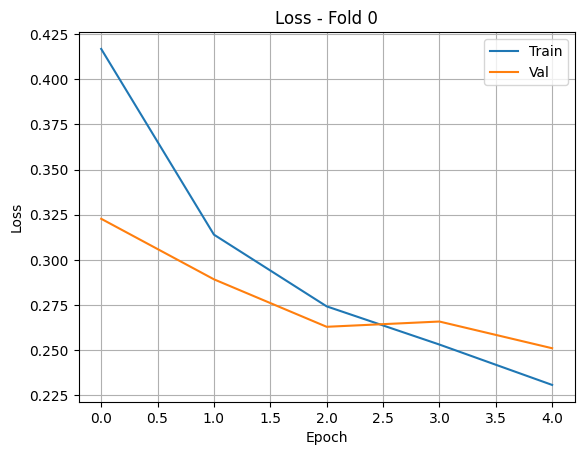

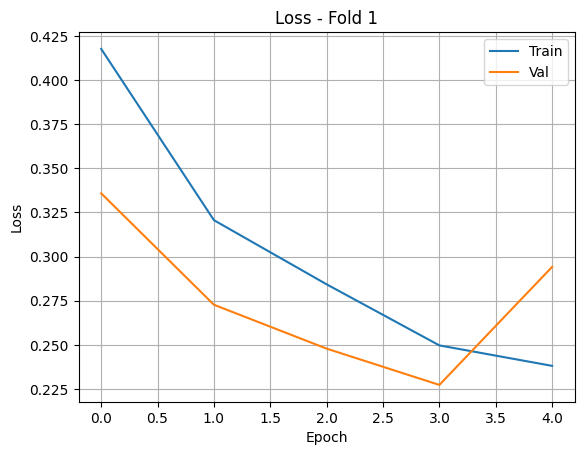

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, ConcatDataset
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, jaccard_score
import segmentation_models_pytorch as smp
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt

# === CONFIG ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint_dir = Path('./checkpoints_smp')
checkpoint_dir.mkdir(exist_ok=True)




# === Cross-validation with SMP UNet++ ===
def train_smp_unetpp_crossval(
    img_dir,
    epochs=5,
    batch_size=8,
    n_classes=2,
    n_channels=8,
    sensor='planet',
    initial_lr=1e-4,
    patience=5,
    n_splits=6,
    train_folds=[0, 1]  # Only train on first two folds
):
    dataset_all = SegmentationDataset(
        img_dir=img_dir,
        augmentation_method='no_augmentation',
        sensor=sensor,
        mode='folder'
    )

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    all_indices = list(range(len(dataset_all)))

    fold_results = []
    best_model = None
    best_val_loss = float('inf')

    for fold, (train_indices, val_indices) in enumerate(kfold.split(all_indices)):
        print(f"\n=== Fold {fold + 1}/{n_splits} ===")

        if fold not in train_folds:
            continue

        train_paths = [dataset_all.img_files[i] for i in train_indices]
        val_paths = [dataset_all.img_files[i] for i in val_indices]

        train_dataset = ConcatDataset([
            SegmentationDataset(img_dir=train_paths, augmentation_method=None, sensor=sensor, mode='list'),
            SegmentationDataset(img_dir=train_paths, augmentation_method='horizontal_flip', sensor=sensor, mode='list'),
            SegmentationDataset(img_dir=train_paths, augmentation_method='vertical_flip', sensor=sensor, mode='list'),
            SegmentationDataset(img_dir=train_paths, augmentation_method='rotate_90', sensor=sensor, mode='list')
        ])

        val_dataset = SegmentationDataset(img_dir=val_paths, augmentation_method=None, sensor=sensor, mode='list')

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

        model = smp.UnetPlusPlus(
            encoder_name="resnext50_32x4d",
            encoder_weights=None,
            in_channels=n_channels,
            classes=n_classes,
            activation=None
        ).to(device)

        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=initial_lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True)

        train_losses, val_losses = [], []
        best_fold_val_loss = float('inf')
        best_val_f1, best_val_iou = 0.0, 0.0

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0

            for images, masks in tqdm(train_loader, desc=f"Fold {fold+1} Epoch {epoch+1}"):
                images = images.to(device)
                masks = masks.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, masks)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            avg_train_loss = running_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            model.eval()
            val_loss, val_f1, val_iou = 0.0, 0.0, 0.0
            with torch.no_grad():
                for images, masks in val_loader:
                    images = images.to(device)
                    masks = masks.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, masks)
                    val_loss += loss.item()

                    preds = torch.argmax(outputs, dim=1).detach().cpu().numpy().flatten()
                    targets = masks.detach().cpu().numpy().flatten()

                    val_f1 += f1_score(targets, preds, average='binary')
                    val_iou += jaccard_score(targets, preds, average='binary')

            avg_val_loss = val_loss / len(val_loader)
            avg_val_f1 = val_f1 / len(val_loader)
            avg_val_iou = val_iou / len(val_loader)
            val_losses.append(avg_val_loss)
            scheduler.step(avg_val_loss)

            print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}, Val Loss = {avg_val_loss:.4f}, F1 = {avg_val_f1:.4f}, IoU = {avg_val_iou:.4f}")

            if avg_val_loss < best_fold_val_loss:
                best_fold_val_loss = avg_val_loss
                best_val_f1 = avg_val_f1
                best_val_iou = avg_val_iou
                torch.save(model.state_dict(), checkpoint_dir / f'smp_best_model_fold{fold}.pth')

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model = model
                torch.save(model.state_dict(), checkpoint_dir / 'smp_best_model_overall.pth')

        fold_results.append({
            'fold': fold,
            'train_losses': train_losses,
            'val_losses': val_losses,
            'best_val_loss': best_fold_val_loss,
            'best_val_f1': best_val_f1,
            'best_val_iou': best_val_iou
        })

        plt.figure()
        plt.plot(train_losses, label='Train')
        plt.plot(val_losses, label='Val')
        plt.title(f'Loss - Fold {fold}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)
        plt.savefig(f'smp_loss_fold{fold}.png')

    return best_model, fold_results

# === Run the function ===
if __name__ == '__main__':
    model, results = train_smp_unetpp_crossval(
        img_dir='/content/chipped_dataset',
        epochs=5,
        batch_size=8,
        n_classes=2,
        n_channels=8,
        sensor='planet',
        train_folds=[0, 1]  # Only first two folds
    )


In [4]:
#!pip install segmentation-models-pytorch --quiet

